# In-class example with some Cassini data #
We'll demo some basic kernal loading, time conversions and position extraction. First we need to import some standard things and especially the SpiceyPy module provided by Andews Annex
> Annex et al., (2020). SpiceyPy: a Pythonic Wrapper for the SPICE Toolkit. Journal of Open Source Software, 5(46), 2050, https://doi.org/10.21105/joss.02050

We'll load (furnsh) some generic kernels like planetary constants, leap seconds, and solar system ephemeris.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spiceypy as spice
from mpl_toolkits.mplot3d import Axes3D

kernel_home = "/Users/shane/Desktop/PTYS_551_code/PTYS_551_kernels/"

In [2]:
spice.furnsh(kernel_home+"CASSINI/pck00010.tpc")
spice.furnsh(kernel_home+"CASSINI/naif0012.tls")
spice.furnsh(kernel_home+"CASSINI/de440s.bsp")

# Time Conversions #
Cassini's position information is in the SPK kernels in the Cassini PDS SPICE archive.  Let's load a few of them so that the first six months after orbit insertion is covered. The LBL files contain the start and stop times of the SPK data (in UTC strings). We'll convert those to Ephemeris times to do the calculations with.

In [6]:
spice.furnsh(kernel_home+"CASSINI/041014R_SCPSE_01066_04199.bsp")
spice.furnsh(kernel_home+"CASSINI/180628RU_SCPSE_04183_04199.bsp")
spice.furnsh(kernel_home+"CASSINI/180628RU_SCPSE_04199_04247.bsp")
spice.furnsh(kernel_home+"CASSINI/180628RU_SCPSE_04247_04336.bsp")
spice.furnsh(kernel_home+"CASSINI/180628RU_SCPSE_04336_05015.bsp")
spice.furnsh(kernel_home+"CASSINI/180628RU_SCPSE_05015_05034.bsp")

utc1 = '2004-06-11T13:58:56'
utc2 = '2005-02-03T11:58:56'

et1 = spice.utc2et(utc1) + 10000
et2 = spice.utc2et(utc2) - 10000
dt   = 1000                                             # Time interval between geometry calculations
et   = np.arange(et1, et2, dt)                          # Array of Ephemeris Times

print(utc1,et1)
print(utc2,et2)

2004-06-11T13:58:56 140244400.18463123
2005-02-03T11:58:56 160694000.18485913


# Frames Matter #
Compare the motion of the Cassini spacecraft through space relative to Saturn and the Solar System Barycenter in an inertial frame (J2000) versus the rotating Saturn frame (IAU_SATURN).

In [11]:
[pos,  ltime]  = spice.spkpos('CASSINI', et, 'J2000', 'LT+S', 'SATURN')
[pos2, ltime]  = spice.spkpos('CASSINI', et, 'J2000', 'LT+S', 'SSB')

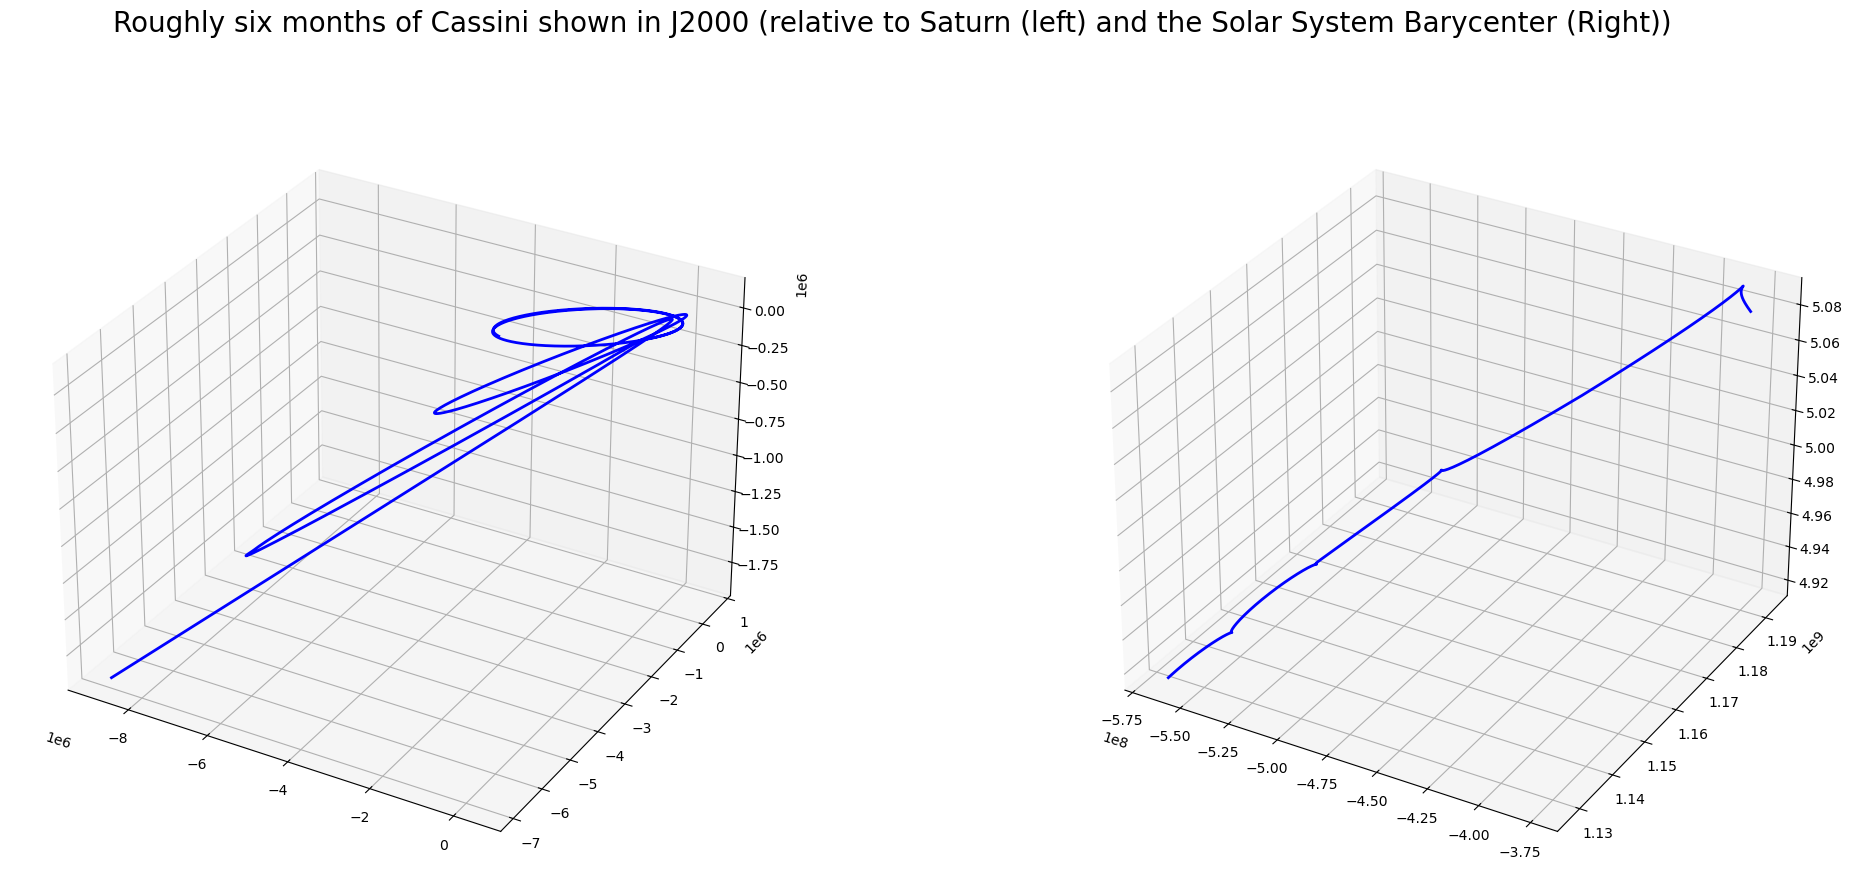

In [12]:
fig = plt.figure(figsize=(25,10))
fig.suptitle('Roughly six months of Cassini shown in J2000 (relative to Saturn (left) and the Solar System Barycenter (Right))', fontsize=20)
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax1.plot(pos[:,0],pos[:,1],pos[:,2],color='Blue',lw=2)
ax2  = fig.add_subplot(gs[0, 1], projection='3d')
ax2.plot(pos2[:,0],pos2[:,1],pos2[:,2],color='Blue',lw=2)

* Note the left plot contains the position (0,0,0), which is where Saturn exists. This plot shows Cassini realtive to Saturn, but still in the inertial J2000 frame.

* Note the right plot does not contain (0,0,0) and has much larger x,y,z values. This plot shows Cassini relative to the center of the Solar System (so the origin is far away). Saturn's motion over these six months is apparent here.

These two plots both use the inertial J2000 frame. What about if we wanted to follow Cassini from some fixed location on Saturn, which is rotating?  This is a non-inertial frame, which SPICE can handle.

In [13]:
[pos3,  ltime]  = spice.spkpos('CASSINI', et, 'IAU_SATURN', 'LT+S', 'SATURN')

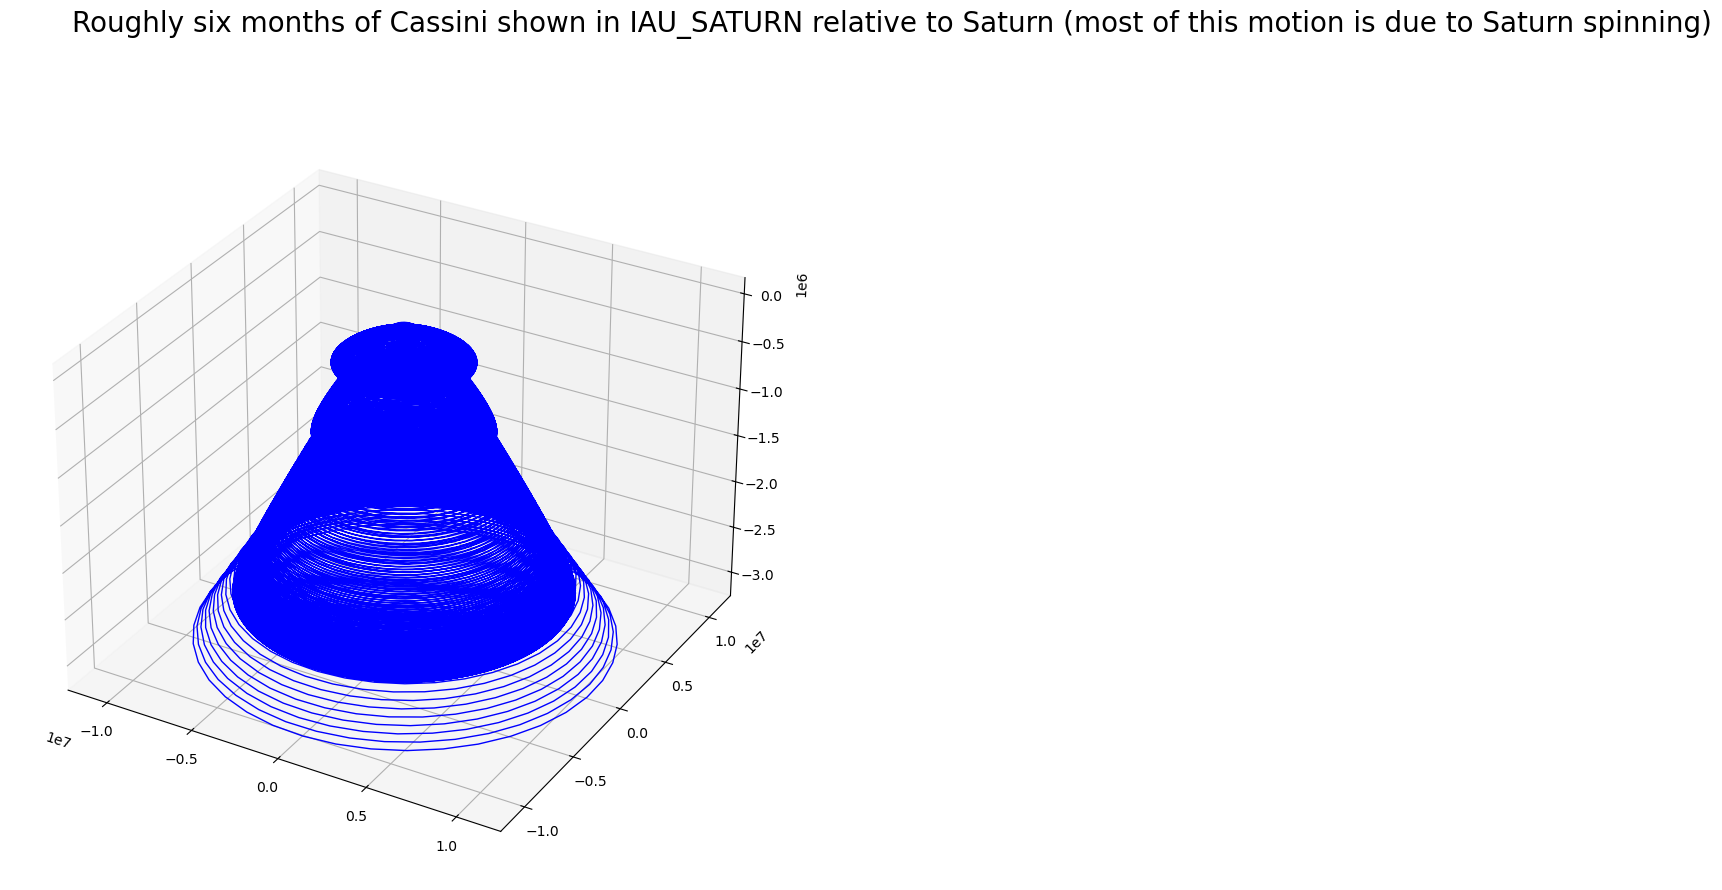

In [14]:
fig = plt.figure(figsize=(25,10))
fig.suptitle('Roughly six months of Cassini shown in IAU_SATURN relative to Saturn (most of this motion is due to Saturn spinning)', fontsize=20)
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax1.plot(pos3[:,0],pos3[:,1],pos3[:,2],color='Blue',lw=1)

# Observing Phoebe #
Here we'll use the Geometry Finder routines to figure out when Phoebe is within the FOV of the ISS camera on Cassini. Phoebe is approximated by an ellipsoid here. First we need a few more kernels that describe the orbit of Phoebe, the orientation of Cassini, the properites of the ISS instrument, and defintion of frames aboard Cassini.

In [25]:
spice.furnsh(kernel_home+"CASSINI/cas_iss_v10.ti")
spice.furnsh(kernel_home+"CASSINI/cas_v41.tf")
spice.furnsh(kernel_home+"CASSINI/cas00172.tsc")
spice.furnsh(kernel_home+"CASSINI/sat359_97288_04003.bsp")

spice.furnsh(kernel_home+"CASSINI/04150_04157ra.bc")
spice.furnsh(kernel_home+"CASSINI/04157_04161ra.bc")
spice.furnsh(kernel_home+"CASSINI/04161_04164ra.bc")
spice.furnsh(kernel_home+"CASSINI/04164_04168ra.bc")
spice.furnsh(kernel_home+"CASSINI/04168_04171ra.bc")
spice.furnsh(kernel_home+"CASSINI/04153_04182ca_ISS.bc")

et1 = spice.str2et('2004 JUN 11 04:30:00 TDB')
et2 = spice.str2et('2004 JUN 12 03:59:59 TDB')

inst   = "CASSINI_ISS_NAC"
target = "PHOEBE"
tshape = "ELLIPSOID"
tframe = "IAU_PHOEBE"
abcorr = "LT+S"
obsrvr = "CASSINI"
stepsz = 5.

cell = spice.cell_double(2)
spice.wninsd(et1,et2,cell)
ww = spice.cell_double(2000)

spice.gftfov(inst,target, tshape, tframe, abcorr, obsrvr, stepsz, cell, ww)

print('Start of Window       End of Window         Distance Range to Phoebe (km)')
print('---------------       -------------         -----------------------------')
for i in range(0,spice.wncard(ww)):
    [zz, xx] = spice.wnfetd(ww,i)
    [pos,  ltime]  = spice.spkpos('PHOEBE', zz, 'J2000', 'LT+S', 'CASSINI')
    [pos2,  ltime]  = spice.spkpos('PHOEBE', xx, 'J2000', 'LT+S', 'CASSINI')
    print(spice.et2utc(zz,'ISOC',1), spice.et2utc(xx,'ISOC',1), np.sqrt(np.sum(np.power(pos,2))).astype(int), ' to ' ,np.sqrt(np.sum(np.power(pos2,2))).astype(int))



Start of Window       End of Window         Distance Range to Phoebe (km)
---------------       -------------         -----------------------------
2004-06-11T04:36:18.7 2004-06-11T04:40:22.8 341979  to  340428
2004-06-11T05:00:16.7 2004-06-11T05:39:22.9 332845  to  317942
2004-06-11T07:34:46.6 2004-06-11T08:47:23.4 273964  to  246291
2004-06-11T09:02:16.1 2004-06-11T09:34:23.5 240621  to  228379
2004-06-11T09:49:16.0 2004-06-11T10:21:23.7 222710  to  210466
2004-06-11T10:36:15.8 2004-06-11T11:08:23.8 204800  to  192554
2004-06-11T11:23:15.5 2004-06-11T11:55:24.2 186891  to  174641
2004-06-11T12:10:15.3 2004-06-11T12:42:24.3 168981  to  156730
2004-06-11T12:57:15.0 2004-06-11T13:18:36.5 151073  to  142934
2004-06-11T15:53:07.2 2004-06-11T19:35:08.0 84061  to  2255
2004-06-11T19:52:43.5 2004-06-11T19:54:09.9 7599  to  8127
2004-06-11T19:58:12.8 2004-06-11T21:34:26.2 9622  to  46091
2004-06-12T02:28:37.1 2004-06-12T02:49:24.0 158160  to  166079
2004-06-12T03:04:15.0 2004-06-12T03:36:23.7